In [1]:
import sys
sys.path.insert(0, r'C:\Users\buzga\Desktop\School\Reaserch\Langone\ML_RA_EHR\DataModule')
sys.path.insert(0, r'C:\Users\buzga\Desktop\School\Reaserch\Langone\ML_RA_EHR')
import matplotlib.pyplot as plt
import Data_Preparation
import evaluate 
import pandas as pd 
import numpy as np
import seaborn as sns
from sklearn import linear_model
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import ensemble


In [2]:
## importing data. 
path=r'C:\Users\buzga\Desktop\School\Reaserch\Langone\ML_RA_EHR\Dataset'
df = Data_Preparation.CoronnaCERTAINDataset(
    library_root=path,
    challenge="regression",
    dataset='CORRONA CERTAIN',
    process_approach='SC',
    imputation='KNN',
    patient_group='bionaive TNF',
    drug_group='all',
    time_points=(0,3),
    train_test_rate=0.8,
    save_csv=False,
    random_state=2022)
train, train_loc = df.get_train()
test, test_loc = df.get_test()
X_train = train.iloc[:,:-1]
y_train = train.iloc[:,-1]
X_test = test.iloc[:,:-1]
y_test = test.iloc[:,-1]


feature engineering, drop columns due to 70% missing value: Index(['smkyrs', 'numcigs', 'rfstatus_impute', 'ccpstatus_impute',
       'statin_use'],
      dtype='object')
save file to: C:\Users\buzga\Desktop\School\Reaserch\Langone\ML_RA_EHR\Dataset\.csv_temp\Train.csv
save file to: C:\Users\buzga\Desktop\School\Reaserch\Langone\ML_RA_EHR\Dataset\.csv_temp\Test.csv


In [3]:
ridge_model = linear_model.RidgeCV()
ridge_model.fit(X_train,y_train)
ridge_preds=ridge_model.predict(X_test)
    

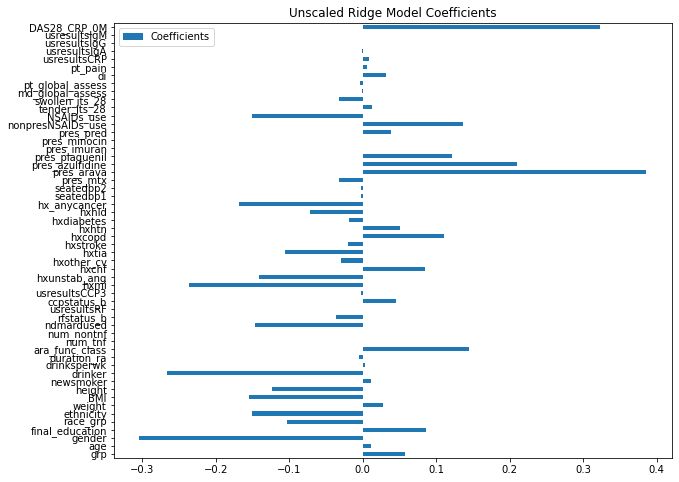

In [4]:
coefs = pd.DataFrame(
   ridge_model.coef_,columns=['Coefficients'],
    index=X_train.columns
)
coefs.plot(kind='barh', figsize=(10, 8))
plt.title('Unscaled Ridge Model Coefficients')
plt.show()

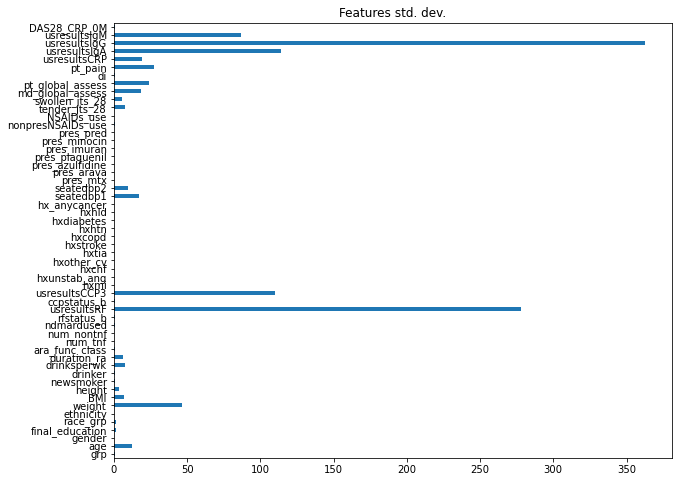

In [5]:
X_train.std(axis=0).plot(kind='barh', figsize=(10, 8))
plt.title('Features std. dev.')
plt.show()

model score on training data: 0.4030345902988248
model score on testing data: 0.20666318018047436


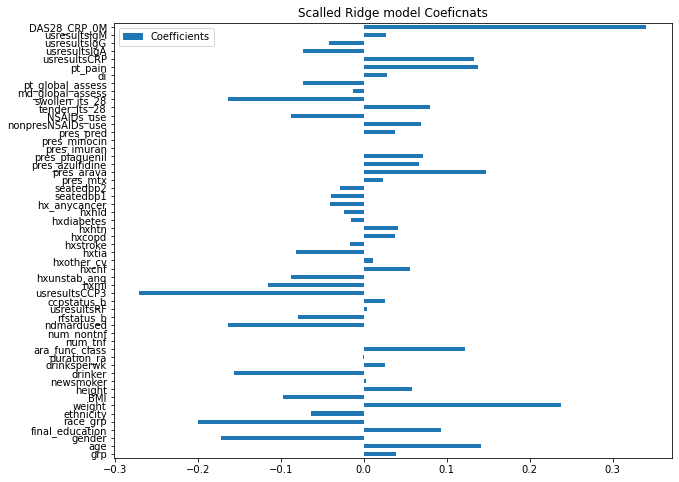

In [6]:
ridge_model = make_pipeline(StandardScaler(), linear_model.RidgeCV())
ridge_model.fit(X_train, y_train)
print(f'model score on training data: {ridge_model.score(X_train, y_train)}')
print(f'model score on testing data: {ridge_model.score(X_test, y_test)}')
coefs = pd.DataFrame(
   ridge_model[1].coef_,
   columns=['Coefficients'], index=X_train.columns
)
coefs.plot(kind='barh', figsize=(10,8))
plt.title('Scalled Ridge model Coeficnats')
plt.show()

model score on training data: 0.39103252184270776
model score on testing data: 0.257744715187329


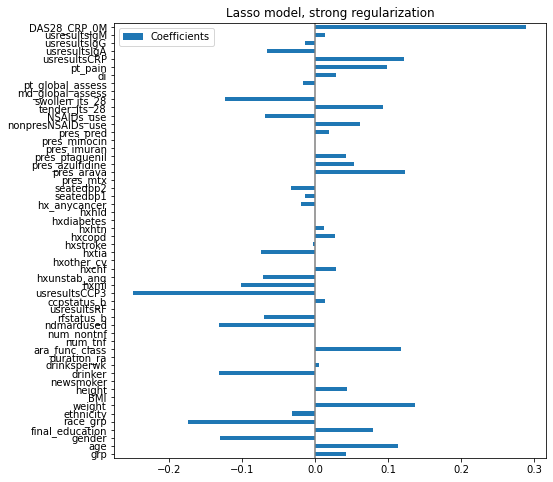

In [7]:
   
lASSO = make_pipeline(StandardScaler(), linear_model.Lasso(alpha=.015))

lASSO.fit(X_train, y_train)
coefs = pd.DataFrame(
   lASSO[1].coef_,
   columns=['Coefficients'], index=X_train.columns
)

coefs.plot(kind='barh', figsize=(10,8))
plt.title('Lasso model, strong regularization')
plt.axvline(x=0, color='.5')
plt.subplots_adjust(left=.3)
print(f'model score on training data: {lASSO.score(X_train, y_train)}')
print(f'model score on testing data: {lASSO.score(X_test, y_test)}')

In [8]:
ridge_base = linear_model.RidgeCV()
ridge_base.fit(X_train,y_train)
ridge_base_preds=ridge_base.predict(X_test)
Lasso_base_model = linear_model.Lasso()
Lasso_base_model.fit(X_train,y_train)
laso_base_preds=Lasso_base_model.predict(X_test)

Text(0.5, 1.0, 'Random Forrest Learned Feature Importance')

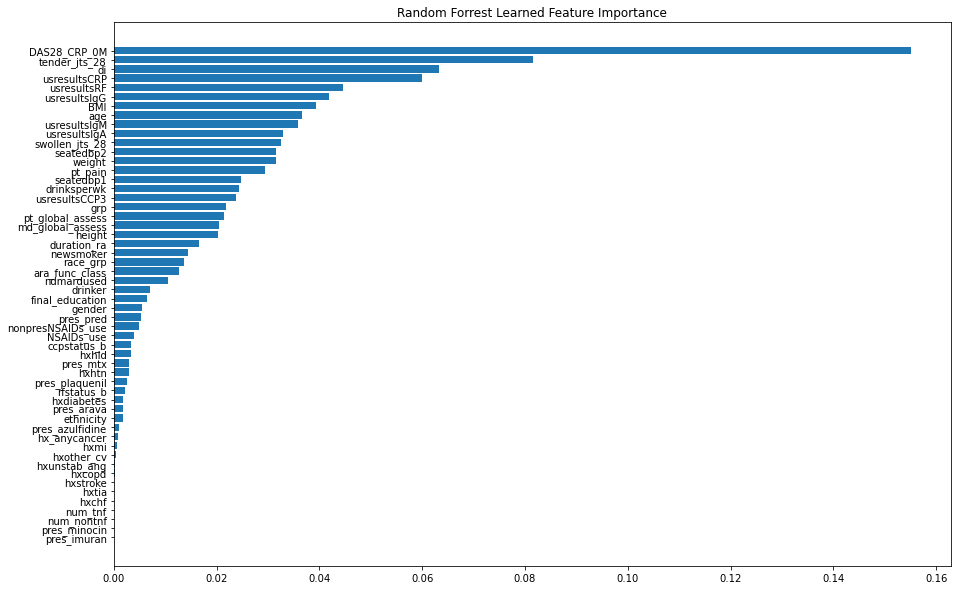

In [9]:

rf = ensemble.RandomForestRegressor(n_estimators=1000)
rf.fit(X_train, y_train)
importances = rf.feature_importances_
indices= np.argsort(importances)
rf_preds=rf.predict(X_test)
fig, ax = plt.subplots()
ax.barh(range(len(importances)), importances[indices])
ax.set_yticks(range(len(importances)))
_ = ax.set_yticklabels(np.array(X_train.columns)[indices])
fig.set_size_inches(15,10)
ax.set_title("Random Forrest Learned Feature Importance")

In [10]:
rf_most_important = ensemble.RandomForestRegressor(n_estimators= 1000)
important = np.array(X_train.columns)[indices][-10:]
features=[x for x in important]
features
#train_important = train_features[:, important_indices]
important_train=X_train[["weight","usresultsIgM", 'age','BMI',
 'usresultsIgG',
 'usresultsRF',
 'di',
 'usresultsCRP',
 'tender_jts_28',
 'DAS28_CRP_0M']]
important_test=X_test[["weight","usresultsIgM", 'age','BMI',
 'usresultsIgG',
 'usresultsRF',
 'di',
 'usresultsCRP',
 'tender_jts_28',
 'DAS28_CRP_0M']]
rf_most_important.fit(important_train, y_train)
important_prerds=rf_most_important.predict(important_test)

In [11]:
aml = evaluate.AutoBuild(seed=1, project_name="EHR_RA_SC")
baseline = test['DAS28_CRP_0M']
true = test['DAS28_CRP_3M']
preds_ridge=ridge_model.predict(X_test)
preds_lasso=lASSO.predict(X_test)
regression, classification = aml.leaderboard()
aml.evaluate("Base Ridge Linear Model", baseline, true, ridge_base_preds)
aml.evaluate("Adjusted Ridge Linear Model", baseline, true, preds_ridge)
aml.evaluate("Base Lasso Linear Model", baseline, true, laso_base_preds)
aml.evaluate("Adjusted Lasso Linear Model", baseline, true, preds_lasso)
aml.evaluate("Random Forrest ", baseline, true, rf_preds)
aml.evaluate("Random Forrest (only top 10 features)", baseline, true, important_prerds)
regression, classification = aml.leaderboard()

In [12]:
regression


,model,MAE,MSE,RMSE,R2,Pearson_Correlation
0,Base Ridge Linear Model,1.021219,1.565438,1.251175,0.204865,0.479908
1,Adjusted Ridge Linear Model,1.010082,1.561897,1.249759,0.206663,0.488367
2,Base Lasso Linear Model,1.073755,1.700617,1.304077,0.136203,0.387454
3,Adjusted Lasso Linear Model,0.976171,1.461329,1.208855,0.257745,0.536313
4,Random Forrest,0.984537,1.417937,1.190771,0.279785,0.603053
5,Random Forrest (only top 10 features),0.998930,1.471372,1.213001,0.252644,0.559020


In [13]:
classification

,model,Accuracy
0,Base Ridge Linear Model,0.441860
1,Adjusted Ridge Linear Model,0.488372
2,Base Lasso Linear Model,0.418605
3,Adjusted Lasso Linear Model,0.523256
4,Random Forrest,0.453488
5,Random Forrest (only top 10 features),0.453488
